<a href="https://colab.research.google.com/github/Henil21/Intro_to_computer_vision_and_CNN/blob/main/Transfer_learning_Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !nvidia-smi

# **Fine-Tuning🌻**


## Lets get some data
How we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

#importing Helper function

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2022-12-16 06:08:09--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-12-16 06:08:09 (74.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2022-12-16 06:08:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.197.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   230MB/s    in 0.7s    

2022-12-16 06:08:14 (230 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [5]:
train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [6]:
import tensorflow as tf
IMG_SIZE=(224,224)
Batch_size=32
train_data=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                      image_size=IMG_SIZE,
                                                                      label_mode="categorical",
                                                                      batch_size=Batch_size)
test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                      image_size=IMG_SIZE,
                                                                      label_mode="categorical",
                                                                      batch_size=Batch_size)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 0: Building transfer learning model using the keras `Functional API`

>The functional API gives us flexibility with our model


Keras Applications are premade architectures with pre-trained weights.

In [8]:
#1 we are using include_top=false beacuse its top layers has 1k output layers 
base_model=tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model
base_model.trainable=False

#3. Create inputs into out model
inputs=tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

# 4. if using like ResNet50V2 you will need to normalize inputs (we dont need for EfficientNet it has built in)
# x= tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. passing input to the base_model
x=base_model(inputs)
print(f"shape after passing inputs through base model:{x.shape}")

# 6.Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x=tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
print(f"shape after passing inputs through global_avg_pooling_layer:{x.shape}")

# 7. Create the Output activation layer
output=tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

# 8. Compile for the model
model_0=tf.keras.Model(inputs,output)
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
history_1=model_0.fit(train_data,
                      epochs=5,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=len(test_data),
                      callbacks=create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent_feature_extraction"))

16705208/16705208 [==============================] - 0s 0us/step
shape after passing inputs through base model:(None, 7, 7, 1280)
shape after passing inputs through global_avg_pooling_layer:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20221216-060824
Epoch 1/5
24/24 [==============================] - 23s 408ms/step - loss: 1.9808 - accuracy: 0.3573 - val_loss: 1.3747 - val_accuracy: 0.7108
Epoch 2/5
24/24 [==============================] - 8s 321ms/step - loss: 1.1489 - accuracy: 0.7373 - val_loss: 0.9038 - val_accuracy: 0.8112
Epoch 3/5
24/24 [==============================] - 8s 324ms/step - loss: 0.8237 - accuracy: 0.8107 - val_loss: 0.7164 - val_accuracy: 0.8452
Epoch 4/5
24/24 [==============================] - 8s 320ms/step - loss: 0.6600 - accuracy: 0.8533 - val_loss: 0.6243 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 8s 316ms/step - loss: 0.5545 - accuracy: 0.8840 - val_loss: 0.5641 - val_accuracy: 0

In [9]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


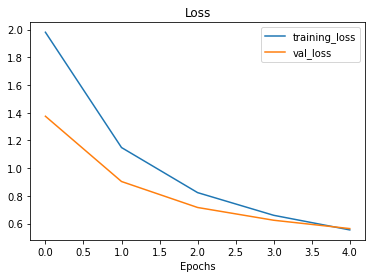

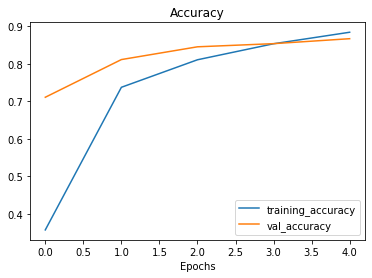

In [10]:
plot_loss_curves(history_1)

## Getting a fearure vector from  a trained model ⛹


let's demonstrate the Global Average Pooling 2D layerss..


we have a tensor after our model goes through `base_model` of shape (None,7,7,1280)



but as we pass it to globalaveragePooling2D it turns into (None,1280).


Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling 2D.



In [14]:
#  define the input shape
input_shape=(1,4,4,3)

# create a random tensor
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)
print(f"random input tensor:\n{input_tensor}\n")

# pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor=tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"global average pooled tensor tensor:\n{global_average_pooled_tensor}\n")

random input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

global average pooled tensor tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]

